In [7]:
import numpy as np
from operator import itemgetter

# SVM(完全に分類可能な場合)

In [61]:
class SVC_hard:
    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1])
        yx = y.reshape(-1, 1) * X
        indices = np.arange(X.shape[0])
        self.w0_history = []
        self.w_history = []
        self.i_history = []
        self.j_history = []
        
        while True:
            ydf = y*(1-np.dot(yx, ayx.T))
            iydf = np.c_[indices, ydf]
            # choice i, j
            i = int(min(iydf[(y<0) | (a>0)], key=itemgetter(1))[0])
            j = int(max(iydf[(y>0) | (a>0)], key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            # calculate optimal i, j
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i,:] - y[j]*a[j]*X[j,:]
            ai = (( 1-y[i]*y[j] + y[i]*np.dot(X[i,:] - X[j,:], X[j, :]*ay2 - ayx2))
                    / ((X[i] - X[j])**2).sum())
            if ai < 0:
                ai = 0
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j] - ay2) * y[i]
            # update a
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i,:] + y[j]*(aj - a[j])*X[j, :]
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
            ind = a != 0.
            self.w_history.append(((a[ind] * y[ind]).reshape(-1, 1) * X[ind,:]).sum(axis=0))
            self.w0_history.append((y[ind] - np.dot(X[ind,:], self.w_history[-1])).sum() / ind.sum())
            self.i_history.append(i)
            self.j_history.append(j)
        self.a_ = a
        # update w
        ind = a != 0. # select a (not equal 0)
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1) * X[ind,:]).sum(axis=0)
        self.w0_ = (y[ind] - np.dot(X[ind,:], self.w_)).sum() / ind.sum()
        
    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))
            

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

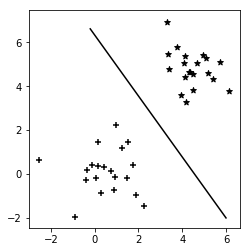

In [64]:
plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([5,5])
y = np.array([1] * 20 + [-1] * 20)
X = np.r_[X0, X1] # mix the two groups

model = SVC_hard()
model.fit(X, y)

plt.scatter(X0[:,0], X0[:,1], color='k', marker='+')
plt.scatter(X1[:,0], X1[:,1], color='k', marker='*')

def f2(model, x):
    return (-model.w0_ - model.w_[0] *x) / model.w_[1]

x1 = -0.2
x2 = 6
plt.plot([x1, x2], [f(model,x1), f(model,x2)], color='k')

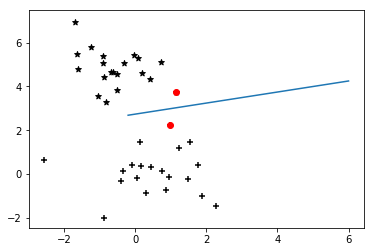

KeyboardInterrupt: 

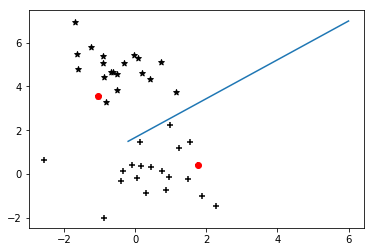

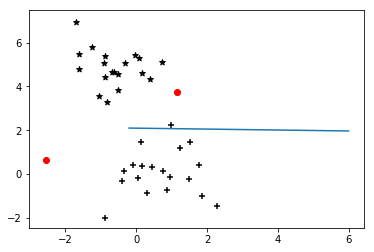

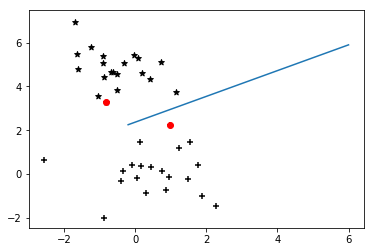

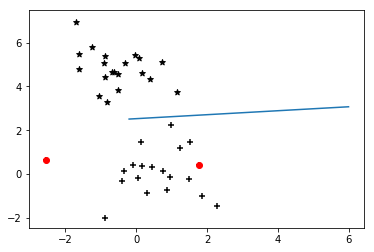

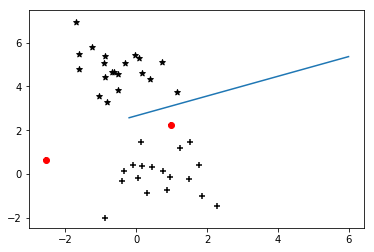

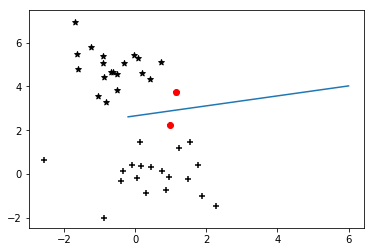

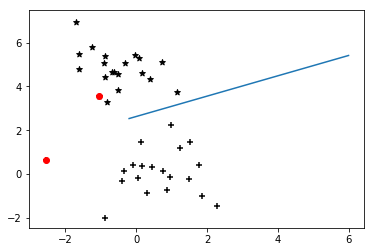

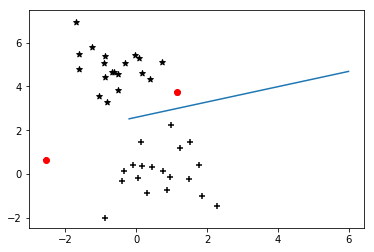

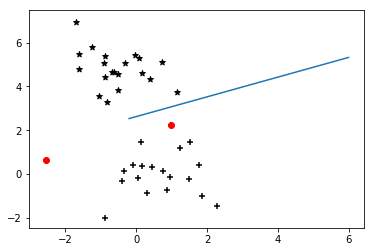

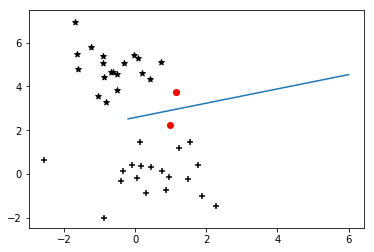

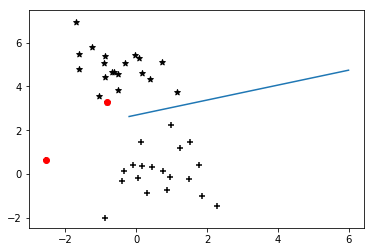

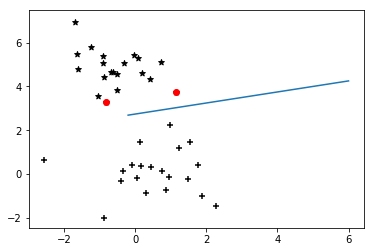

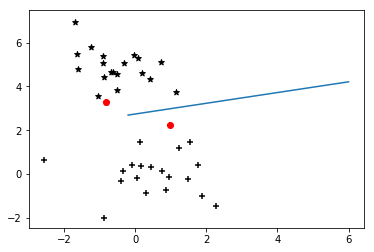

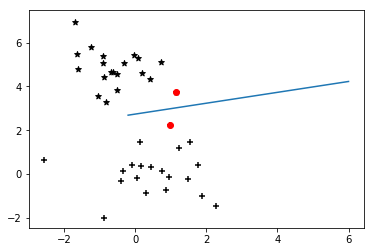

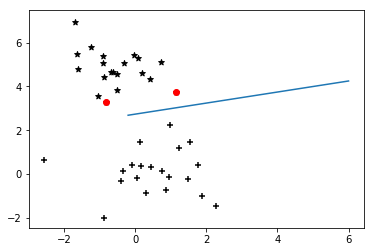

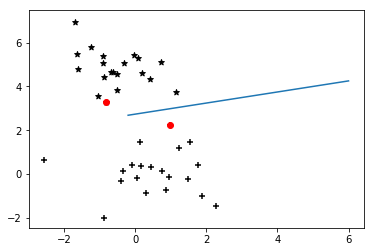

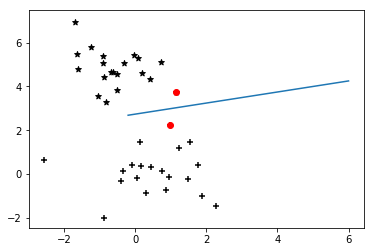

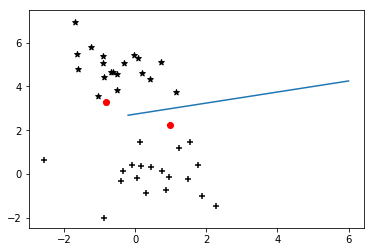

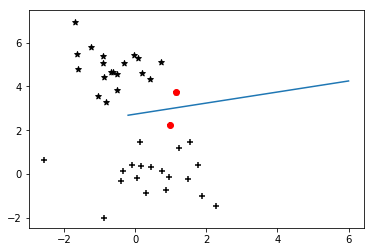

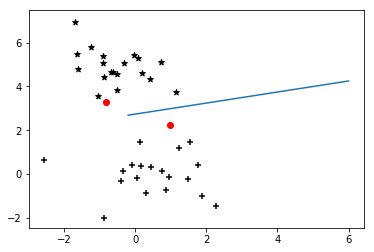

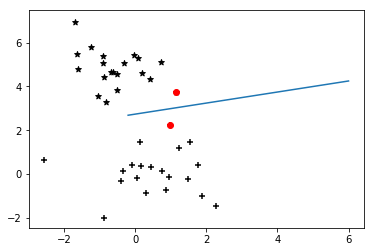

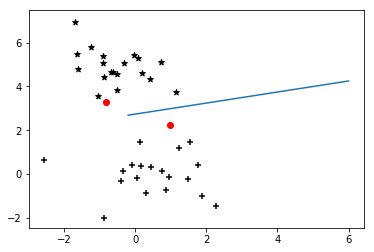

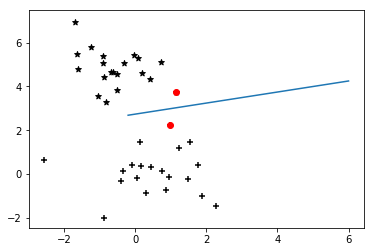

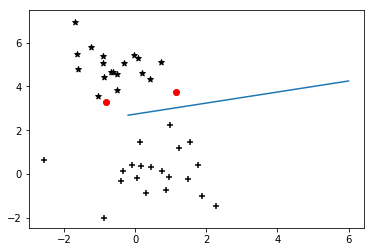

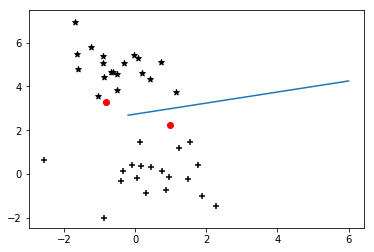

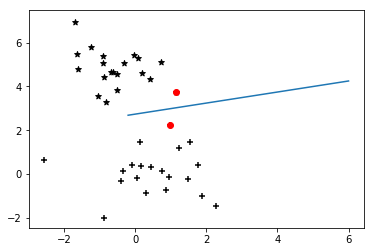

In [90]:
#plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([0,5])
y = np.array([-1] * 20 + [1] * 20)
X = np.r_[X0, X1] # mix the two groups

model = SVC_hard()
model.fit(X, y)

def f2(w0_, w_, x):
    return (-w0_ - w_[0] *x) / w_[1]

x1 = -0.2
x2 = 6

from IPython import display
import time


for i in range(len(model.w_history)):
    w0 = model.w0_history[i]
    w = model.w_history[i]
    i_ = model.i_history[i]
    j_ = model.j_history[i]
    fig, ax = plt.subplots()
    ax.scatter(X0[:,0], X0[:,1], color='k', marker='+')
    ax.scatter(X1[:,0], X1[:,1], color='k', marker='*')
    ax.scatter(X[i_,0], X[i_,1], color='r', marker='o')
    ax.scatter(X[j_,0], X[j_,1], color='r', marker='o')
    ax.plot([x1, x2], [f2(w0,w,x1), f2(w0,w,x2)])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(2.)
    

# 軌跡を表示できるバージョン

In [70]:
for i in range(len(model.w_history)):
    w0 = model.w0_history[i]
    w = model.w_history[i]
    plt.scatter(X0[:,0], X0[:,1], color='k', marker='+')
    plt.scatter(X1[:,0], X1[:,1], color='k', marker='*')
    plt.plot([x1, x2], [f2(w0,w,x1), f2(w0,w,x2)])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.)

# SVM(完全に分類可能な場合)

In [17]:
class SVC_soft:
    def __init__(self,C=1.):
        self.C = C
        
    def fit(self,X,y,selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1])
        yx = y.reshape(-1,1) * X
        indices = np.arange(X.shape[0])
        while True:
            ydf = y*(1-np.dot(yx, ayx.T))
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a>0) & (y>0)) | ((a<self.C) & (y<0))],
                       key = itemgetter(1))[0])
            j = int(max(iydf[((a>0) & (y<0)) | ((a<self.C) & (y>0))],
                       key = itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i,:] - y[j]*a[j]*X[j,:]
            ai = ((1 - y[i]*y[j] + y[i]*np.dot(X[i,:]-X[j,:],X[j,:]*ay2-ayx2)) / ((X[i]-X[j])**2).sum())
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j] - ay2) * y[i]
            elif aj > self.C:
                aj = self.C
                ai = (-aj*y[j]-ay2) * y[i]
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i,:] + y[j]*(aj - a[j])*X[j,:]
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        ind = a != 0.
        self.w_ = ((a[ind]*y[ind]).reshape(-1,1) * X[ind,:]).sum(axis=0)
        self.w0_ = (y[ind] - np.dot(X[ind,:], self.w_)).sum() / ind.sum()
        
    def predict(self,X):
        return np.sign(self.w0_ + np.dot(X, self.w_))

Right classified: 37


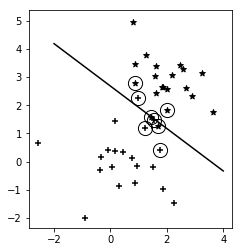

In [18]:
plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([2.5, 3])
y = np.array([1] * 20 + [-1] * 20)

X = np.r_[X0, X1]
model = SVC_soft()
model.fit(X,y)

plt.scatter(X0[:,0], X0[:,1], color="k", marker="
plt.plot([x1,x2], [f(model,x1),f(model,x2)], color="k")
print("Right classified:", (model.predict(X)==y).sum())
plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1], s=200, 
            color=(0,0,0,0), edgecolor="k", marker="o")

def f(model, xx):
    return model.w0_ + np.dot(model.w_, xx)

plt.show()